In [241]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

In [308]:
ratings = pd.read_csv('../data/recommendation_system/ratings.csv')
movies = pd.read_csv('../data/recommendation_system/movies.csv')

In [309]:
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [310]:
ratings.shape

(100836, 4)

In [311]:
data = pd.pivot_table(
    data=ratings,
    columns='movieId',
    index='userId',
    values='rating'
)

In [312]:
data.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [313]:
train_data, test_data = train_test_split(data, test_size=0.1, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

In [314]:
train_data.shape

(494, 9724)

In [315]:
val_data.shape

(55, 9724)

In [316]:
test_data.shape

(61, 9724)

In [317]:
data.size

5931640

In [318]:
def sparsity_calculation(data):
    data = np.nan_to_num(data)
    return round(1. - np.count_nonzero(data) / data.size, 3) * 100

In [319]:
sparsity_calculation(data)

98.3

In [320]:
sparsity_calculation(train_data)

98.4

In [321]:
sparsity_calculation(val_data)

98.6

In [322]:
sparsity_calculation(test_data)

97.6

In [323]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)

/Users/bruno.guimaraes/.virtualenvs/NeuralNetworks_Course/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/bruno.guimaraes/.virtualenvs/NeuralNetworks_Course/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


MinMaxScaler(feature_range=(-1, 1))

In [324]:
train = pd.DataFrame(scaler.transform(train_data), index=train_data.index, columns=train_data.columns).fillna(0)
val = pd.DataFrame(scaler.transform(val_data), index=val_data.index, columns=val_data.columns).fillna(0)
test = pd.DataFrame(scaler.transform(test_data), index=test_data.index, columns=test_data.columns).fillna(0)

In [325]:
val

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
155,0.111111,0.000000,0.000000,0.0,0.000000,0.00,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
189,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
296,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
421,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
493,0.000000,0.000000,0.000000,0.0,0.000000,0.50,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
390,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
183,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
411,1.000000,0.555556,0.000000,0.0,0.000000,0.00,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
535,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [260]:
n_movies = len(data.columns)

In [289]:
def encoder(input_layer):

    x = tf.keras.layers.Dense(units=100, activation='relu')(input_layer)
    x = tf.keras.layers.Dense(units=50, activation='relu')(x)
    x = tf.keras.layers.Dense(units=10, activation='relu')(x)

    return x

def decoder(x):

    x = tf.keras.layers.Dense(units=10, activation='relu')(x)
    x = tf.keras.layers.Dense(units=50, activation='relu')(x)
    x = tf.keras.layers.Dense(units=100, activation='relu')(x)
    output_layer = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    return output_layer

def movie_recommender(n_movies):

    input_layer = tf.keras.layers.Input(
        shape=(n_movies, ),
        dtype=tf.float32,
        name='input_layer'
    )

    x = tf.keras.layers.Dense(units=100, activation='relu')(input_layer)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(units=50, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(units=10, activation='relu')(x)
    x = tf.keras.layers.Dense(units=10, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(units=50, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(units=100, activation='relu')(x)
    output_layer = tf.keras.layers.Dense(units=n_movies)(x)

    model = tf.keras.models.Model(
        inputs=[input_layer],
        outputs=[output_layer]
    )
    model.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['mae']
    )

    return model

In [290]:
model = movie_recommender(n_movies)

In [291]:
model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 9724)]            0         
                                                                 
 dense_50 (Dense)            (None, 100)               972500    
                                                                 
 batch_normalization (BatchN  (None, 100)              400       
 ormalization)                                                   
                                                                 
 dense_51 (Dense)            (None, 50)                5050      
                                                                 
 batch_normalization_1 (Batc  (None, 50)               200       
 hNormalization)                                                 
                                                                 
 dense_52 (Dense)            (None, 10)                510

In [292]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

In [293]:
history = model.fit(
    train,
    train,
    validation_data=(val, val),
    epochs=100,
    batch_size=12,
    callbacks=[callback]
)

Epoch 1/100
42/42 [==============================] - 2s 13ms/step - loss: 0.0089 - mae: 0.0388 - val_loss: 0.0150 - val_mae: 0.0125
Epoch 2/100
42/42 [==============================] - 0s 8ms/step - loss: 0.0076 - mae: 0.0260 - val_loss: 0.0150 - val_mae: 0.0130
Epoch 3/100
42/42 [==============================] - 0s 8ms/step - loss: 0.0073 - mae: 0.0224 - val_loss: 0.0149 - val_mae: 0.0136
Epoch 4/100
42/42 [==============================] - 0s 8ms/step - loss: 0.0072 - mae: 0.0212 - val_loss: 0.0148 - val_mae: 0.0138
Epoch 5/100
42/42 [==============================] - 0s 8ms/step - loss: 0.0071 - mae: 0.0204 - val_loss: 0.0148 - val_mae: 0.0139
Epoch 6/100
42/42 [==============================] - 0s 9ms/step - loss: 0.0071 - mae: 0.0198 - val_loss: 0.0148 - val_mae: 0.0141
Epoch 7/100
42/42 [==============================] - 0s 9ms/step - loss: 0.0070 - mae: 0.0191 - val_loss: 0.0148 - val_mae: 0.0141
Epoch 8/100
42/42 [==============================] - 0s 10ms/step - loss: 0.0070 -

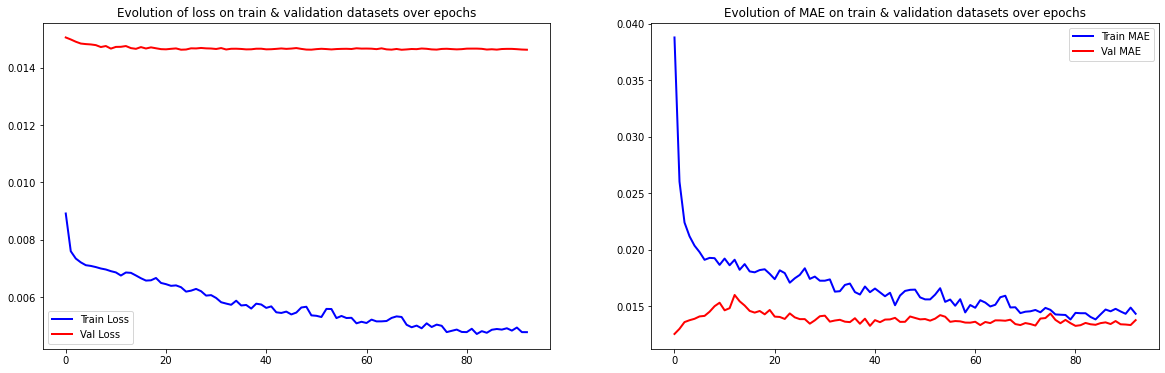

In [294]:
epoch_loss = history.history['loss']
epoch_val_loss = history.history['val_loss']
epoch_mae = history.history['mae']
epoch_val_mae = history.history['val_mae']

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_mae)), epoch_mae, 'b-', linewidth=2, label='Train MAE')
plt.plot(range(0,len(epoch_val_mae)), epoch_val_mae, 'r-', linewidth=2,label='Val MAE')
plt.title('Evolution of MAE on train & validation datasets over epochs')
plt.legend(loc='best')

plt.show()

In [326]:
predictions = model.predict(test)

In [327]:
predictions = pd.DataFrame(scaler.inverse_transform(predictions), columns=test.columns, index=test.index)

In [329]:
test_data.reset_index()

movieId,userId,1,2,3,4,5,6,7,8,9,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
0,82,2.5,3.0,NaN,NaN,NaN,3.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,219,3.5,2.5,NaN,NaN,NaN,3.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,599,3.0,2.5,1.5,NaN,NaN,4.5,2.5,NaN,1.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,265,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,606,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57,269,5.0,NaN,4.0,NaN,3.0,5.0,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59,517,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [331]:
predictions = predictions.reset_index()
test_data = test_data.reset_index()

In [332]:
predictions = predictions.melt(id_vars='userId', var_name='movieId', value_name='predicted_ratings')

In [336]:
test_data = test_data.melt(id_vars='userId', var_name='movieId', value_name='ratings').fillna(0)

In [337]:
predictions.head()

,userId,movieId,predicted_ratings
0,82,1,3.075350
1,219,1,3.225283
2,56,1,3.144926
3,599,1,4.742270
4,265,1,3.095882


In [338]:
test_data.head()

,userId,movieId,ratings
0,82,1,2.5
1,219,1,3.5
2,56,1,0.0
3,599,1,3.0
4,265,1,0.0


In [339]:
results = pd.merge(predictions, test_data, on=['userId', 'movieId'], how='inner')

In [340]:
results = pd.merge(results, movies[['movieId', 'title', 'genres']], on='movieId', how='inner')

In [341]:
results[results['userId'] == 82].sort_values(by='predicted_ratings', ascending=False)

,userId,movieId,predicted_ratings,ratings,title,genres
214537,82,4813,5.504531,0.0,When Worlds Collide (1951),Sci-Fi
238083,82,5490,5.501542,0.0,The Big Bus (1976),Action|Comedy
251015,82,5915,5.501482,0.0,Victory (a.k.a. Escape to Victory) (1981),Action|Drama|War
538081,82,132333,5.501451,0.0,Seve (2014),Documentary|Drama
291153,82,7121,5.501249,0.0,Adam's Rib (1949),Comedy|Romance
...,...,...,...,...,...,...
589809,82,184053,NaN,0.0,Battle Planet (2008),Action|Sci-Fi
590480,82,184997,NaN,0.0,"Love, Simon (2018)",Comedy|Drama
590602,82,185031,NaN,0.0,Alpha (2018),Adventure|Thriller
591517,82,188751,NaN,0.0,Mamma Mia: Here We Go Again! (2018),Comedy|Romance


In [342]:
predictions

,userId,movieId,predicted_ratings
0,82,1,3.075350
1,219,1,3.225283
2,56,1,3.144926
3,599,1,4.742270
4,265,1,3.095882
...,...,...,...
593159,606,193609,4.498168
593160,269,193609,4.500163
593161,30,193609,4.497249
593162,517,193609,4.499948
